# Cybersecurity Threat Detection using AWS CloudWatch Logs

This project aims to detect suspicious web traffic using anomaly detection and classification models based on AWS CloudWatch logs.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")


In [10]:
# Load the dataset
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')

# Display basic information
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [11]:
# Convert time-related columns to datetime format
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Drop duplicates if any
df.drop_duplicates(inplace=True)


In [12]:
# Session duration
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

# Average packet size
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['session_duration']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


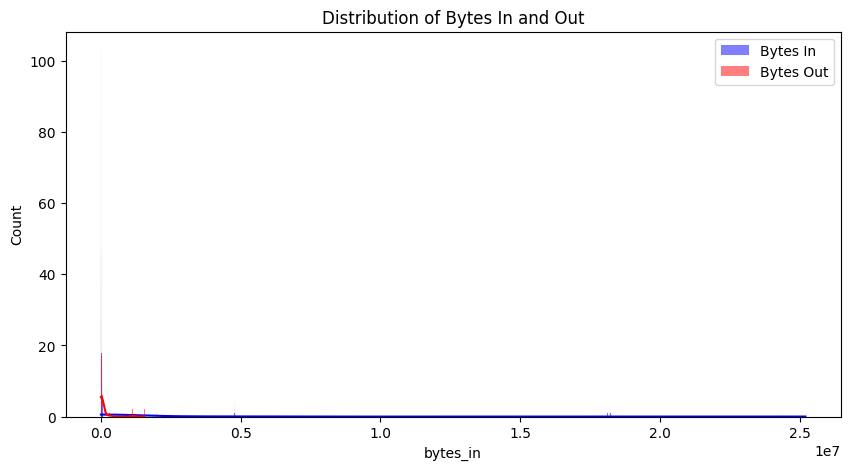

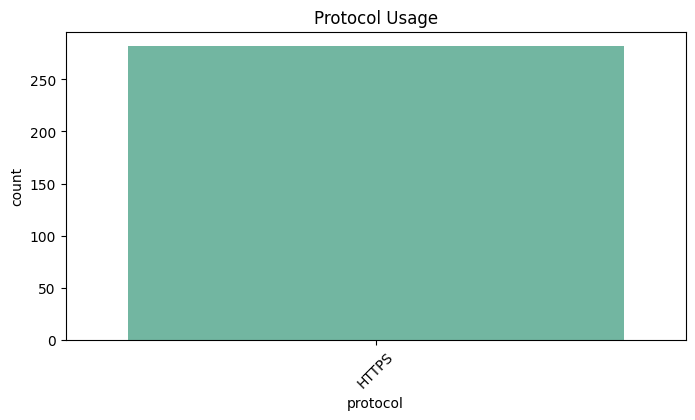

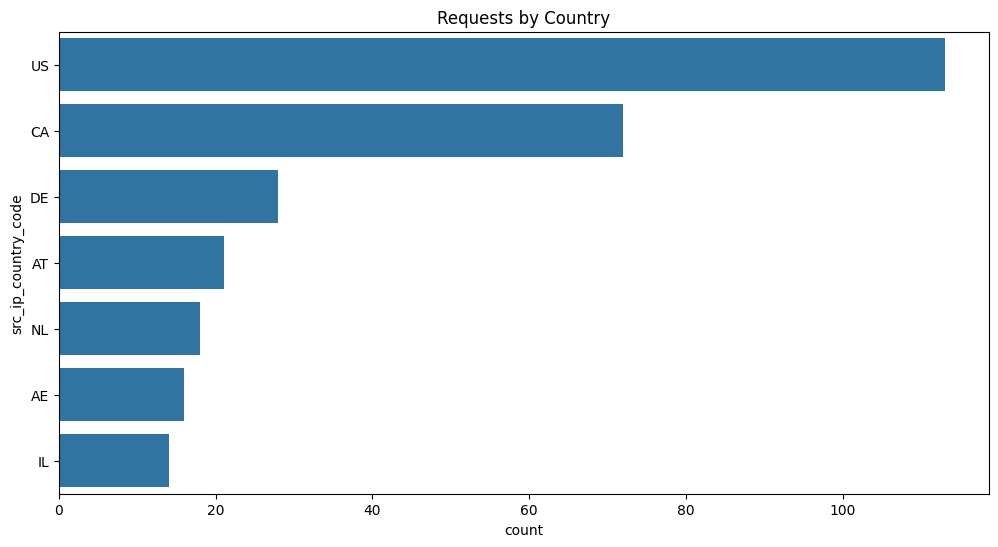

In [13]:
# Traffic byte distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['bytes_in'], color='blue', label='Bytes In', kde=True)
sns.histplot(df['bytes_out'], color='red', label='Bytes Out', kde=True)
plt.legend()
plt.title('Distribution of Bytes In and Out')
plt.show()

# Protocol distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='protocol', data=df, palette='Set2')
plt.title('Protocol Usage')
plt.xticks(rotation=45)
plt.show()

# Source IP country analysis
plt.figure(figsize=(12, 6))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index)
plt.title('Requests by Country')
plt.show()


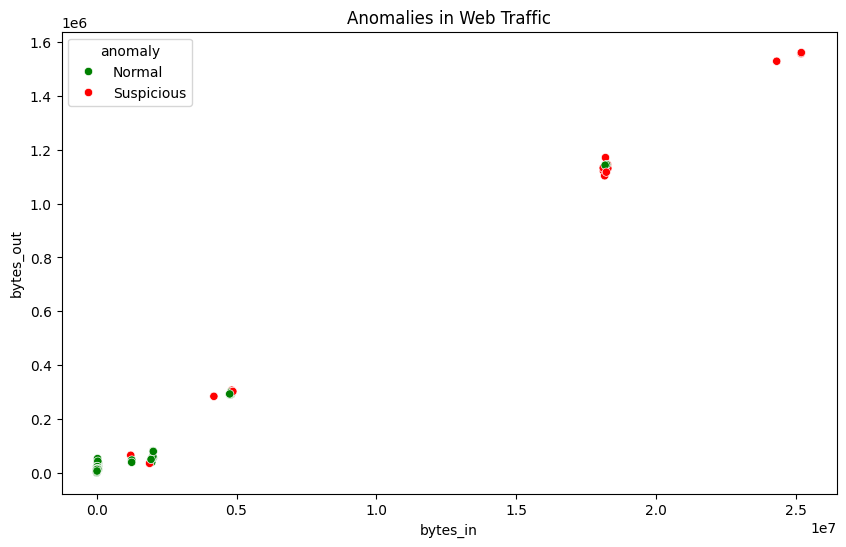

In [14]:
# Isolation Forest
features = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
isolation_model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = isolation_model.fit_predict(features)
df['anomaly'] = df['anomaly'].map({-1: 'Suspicious', 1: 'Normal'})

# Visualize anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df, palette={'Normal': 'green', 'Suspicious': 'red'})
plt.title('Anomalies in Web Traffic')
plt.show()


In [15]:
# Label encoding for detection type
df['is_suspicious'] = (df['detection_types'] == 'waf_rule').astype(int)

# Feature selection
X = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
y = df['is_suspicious']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save model as pickle
with open("cybersecurity_rf_model.pkl", "wb") as f:
    pickle.dump((rf, scaler), f)


Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

